In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import yaml
from king_tensor.screen import Screen

In [2]:
%matplotlib inline

In [3]:
root_dir = pathlib.Path().resolve().parents[0]
data_dir = root_dir / 'data'
img_dir = data_dir / 'card_templates'
config_dir = root_dir / 'king_tensor' / 'config' / 'ui.yaml'

In [6]:
with open(config_dir, 'r') as file:
    config_dict = yaml.safe_load(file)

Here is the Pekka image from RoyalAPI:

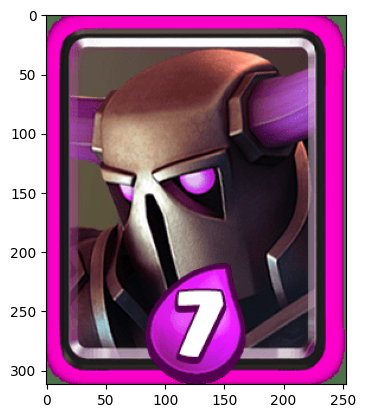

In [39]:
images = [cv2.imread(path) for path in img_dir.glob('*.png')]
pekka = images[0]
plt.imshow(pekka)
plt.show()

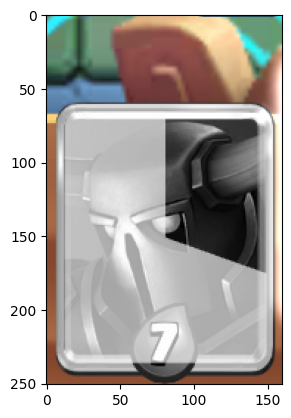

In [40]:
board_image = cv2.imread(data_dir / 'IMG_1470.PNG')
screen = Screen(board_image, config_dict)
images = []
images.append(screen.images['card_slot_1'])
images.append(screen.images['card_slot_2'])
images.append(screen.images['card_slot_3'])
images.append(screen.images['card_slot_4'])
card_ids = ['magic archer', 'bandit', 'pekka', 'fireball']
plt.imshow(images[2])
plt.show()

In [41]:
best_match = 0
for image, troop in zip(images, card_ids):
    match = cv2.matchTemplate(pekka, image, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(match)
    print(troop, max_val)
    best_match = max(max_val, best_match) 

print(best_match)

magic archer 0.19855478405952454
bandit 0.11871126294136047
pekka 0.2836908996105194
fireball 0.2139986902475357
0.2836908996105194


Our bot wrongfully concludes that this card is a fireball. I think the problem is that the cards are not the same scale, so let's do some edge detection to try to create a good crop of our very rough crop

In [42]:
img = images[2]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-622.0..624.0].


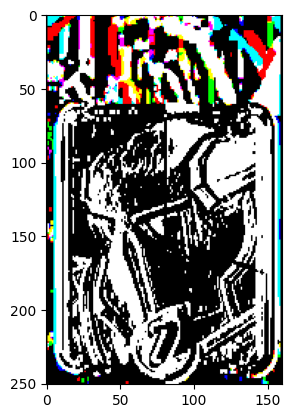

In [43]:
vert_edges = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
plt.imshow(vert_edges)
plt.show()

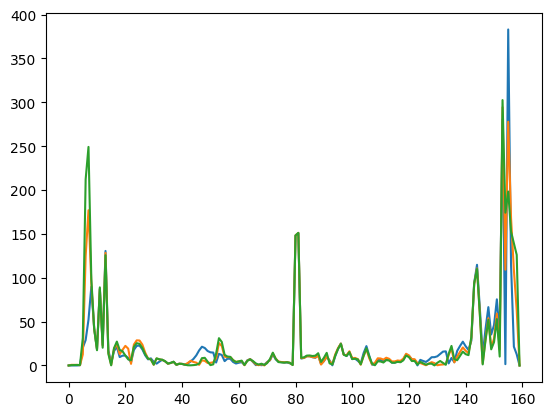

In [44]:
plt.plot(np.abs(vert_edges.mean(axis=0)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-849.0..1020.0].


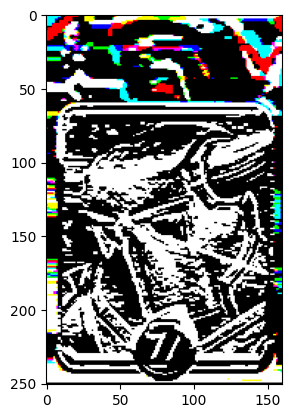

In [45]:
hor_edges = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
plt.imshow(hor_edges)
plt.show()

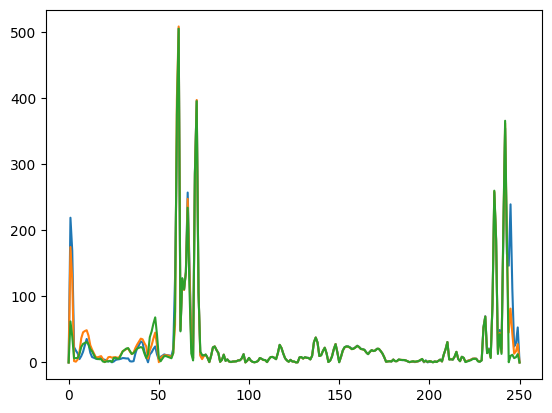

In [46]:
plt.plot(np.abs(hor_edges.mean(axis=1)))

We can try doing some smoothing to pick out the card borders

In [57]:
def smooth_1d(x, k=5):
    """Simple moving-average smoothing."""
    if k <= 1:
        return x
    kernel = np.ones(k, dtype=np.float32) / k
    return np.convolve(x, kernel, mode="same")

def find_card_roi_by_peaks(img_bgr, margin_frac=0.25, pad=3):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    v_profile = np.abs(sobel_x).mean(axis=0)
    h_profile = np.abs(sobel_y).mean(axis=1)

    H, W = gray.shape

    # search windows near each side (don’t let “middle noise” dominate)
    mW = int(W * margin_frac)
    mH = int(H * margin_frac)

    # left border: best peak in [0, mW)
    left_idx = np.argmax(v_profile[:mW])
    # right border: best peak in (W-mW, W]
    right_idx = W - mW + np.argmax(v_profile[W - mW:])

    # top border: best peak in [0, mH)
    top_idx = np.argmax(h_profile[:mH])
    # bottom border: best peak in (H-mH, H]
    bot_idx = H - mH + np.argmax(h_profile[H - mH:])

    x1 = max(left_idx - pad, 0)
    x2 = min(right_idx + pad, W - 1)
    y1 = max(top_idx - pad, 0)
    y2 = min(bot_idx + pad, H - 1)

    roi = img_bgr[y1:y2+1, x1:x2+1]
    return roi, (x1, y1, x2, y2)


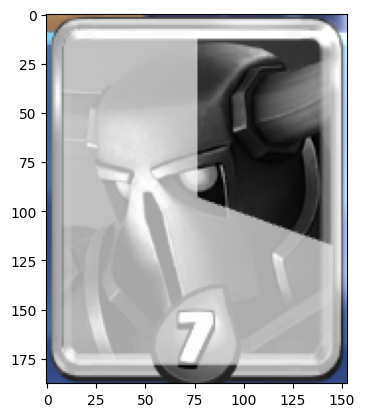

In [58]:
roi, (x1, y1, x2, y2) = find_card_roi_by_peak s(img)
plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
plt.show()


In [55]:
def find_card_roi(img_bgr):
    # 1) grayscale + slight blur (reduces tiny noisy edges)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # 2) Canny edges (often cleaner than raw Sobel for detection)
    edges = cv2.Canny(gray, 50, 150)

    # 3) Dilate a bit so gaps in the border get connected
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)

    # 4) Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)

    # 5) Choose the contour that looks like the card:
    #    - reasonably large
    #    - aspect ratio ~ of a card (e.g. taller than wide)
    h, w = gray.shape
    best = None
    best_score = 0

    for cnt in contours:
        x, y, cw, ch = cv2.boundingRect(cnt)
        area = cw * ch
        if area < 0.1 * w * h:    # skip tiny stuff
            continue

        ar = ch / cw
        # tune these for your card shape
        if 1.3 < ar < 2.5:        # tall-ish rectangle
            score = area          # or some other heuristic
            if score > best_score:
                best_score = score
                best = (x, y, cw, ch)

    if best is None:
        return None

    x, y, cw, ch = best
    print(x, y, cw, ch)
    roi = img_bgr[y:y+ch, x:x+cw]
    return roi

0 0 160 251


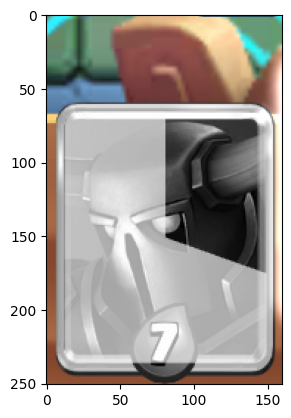

In [56]:
plt.imshow(find_card_roi(img))
plt.show()